# **Preprocessing Pipeline for Multimodal Mental Rotation Dataset**

### **Overview**

This project is part of IITB EdTech Internship, focused on predicting the correctness of participants’ responses in mental rotation tasks using multimodal physiological and behavioral data.

### **Objective:**

Build a binary classification model to predict whether a participant's response is correct (1) or incorrect (0) using data from:

| File Name  | Purpose                                                    |
| ---------- | ---------------------------------------------------------- |
| `PSY.csv`  | Question metadata, timestamps, verdict (Correct/Incorrect) |
| `EEG.csv`  | Brainwave activity across frequency bands                  |
| `EYE.csv`  | Pupil size, gaze tracking data                             |
| `IVT.csv`  | Fixation and saccade information                           |
| `GSR.csv`  | Skin conductance (stress/arousal indicators)               |
| `TIVA.csv` | Facial emotion metrics                                     |







## **Preprocessing Goals**

The main goal of preprocessing is to transform raw multimodal data into per-question feature vectors that are ready for machine learning models.

*Each row in the preprocessed dataset represents :*
* A single question attempt by a participant
* A target label (verdict: Correct/Incorrect).
* Aggregated features derived from all four modalities within the routineStart and routineEnd timestamps

## **Required Libraries for Preprocessing and EDA**

- **pandas (`pd`)** — Data handling and manipulation (loading CSVs, merging features, computing trial-level summaries).  
- **numpy (`np`)** — Numerical operations, safe handling of arrays, and computations like mean, std, ratios.  
- **os** — File and directory handling for per-participant multimodal data.  
- **scipy.signal.find_peaks** — Identify peaks in GSR signals to quantify physiological spikes per trial.  
- **matplotlib.pyplot (`plt`)** — Basic plotting functions for visualizing distributions, scatter plots, and line plots.  
- **seaborn (`sns`)** — Advanced statistical visualizations (histograms, boxplots, violin plots, correlation heatmaps) for EDA.  

**Purpose in pipeline:**  
These libraries provide the core functionality for **loading, preprocessing, feature extraction, and visualization** of EEG, Eye, IVT, GSR, TIVA, and PSY data in your multimodal mental rotation study.


In [2]:
import pandas as pd
import numpy as np
import os
from scipy.signal import find_peaks
import matplotlib.pyplot as plt
import seaborn as sns


## **Helper Functions for Safe Preprocessing and Visualization**

**safe_mean(arr)** and **safe_std(arr)**  
- Compute mean and standard deviation while safely ignoring NaN values.  
- **Purpose:** Avoid exceptions from empty slices or missing data segments, which are very common in multimodal experiments.  
- Ensures that the **entire preprocessing pipeline does not crash** even if some trials lack data in certain modalities.

**plot_distribution(df, cols, title)**  
- Visualizes distributions of multiple features in a compact format.  
- **Purpose:** Quickly inspect distributional shapes, detect outliers, and compare feature scales across modalities.  

**Usage in pipeline:**  
- `safe_mean` and `safe_std` are used in EEG, Eye, IVT, GSR, and TIVA feature extraction to summarize trial-level signals.  
- `plot_distribution` helps perform **exploratory data analysis (EDA)** before model building, ensuring features are reasonable and highlighting potential preprocessing issues.


In [3]:
# ================= HELPER FUNCTIONS =================
def safe_mean(arr):
    """Compute mean safely ignoring NaNs"""
    arr = pd.to_numeric(arr, errors='coerce').dropna()
    return arr.mean() if len(arr) > 0 else np.nan

def safe_std(arr):
    """Compute standard deviation safely ignoring NaNs"""
    arr = pd.to_numeric(arr, errors='coerce').dropna()
    return arr.std() if len(arr) > 0 else np.nan

# For visualizing distributions of features
def plot_distribution(df, cols, title):
    plt.figure(figsize=(12,4))
    for i, col in enumerate(cols):
        plt.subplot(1,len(cols),i+1)
        sns.histplot(df[col].dropna(), kde=True)
        plt.title(col)
    plt.suptitle(title)
    plt.show()

## **Paths and Constants**

- **DATA_DIR**: Raw dataset location.  
- **PREPROCESS_DIR**: Folder to save preprocessed features. Created if missing.  

In [4]:
# ================= PATHS =================
DATA_DIR = "/content/drive/MyDrive/IITBinternship/STData/"
PREPROCESS_DIR = "/content/drive/MyDrive/IITBinternship/Finalpreprocess/"
os.makedirs(PREPROCESS_DIR, exist_ok=True)

NUM_PARTICIPANTS = 38

## **PSY.csv**
PSY.csv contains per-question trial metadata and the **target** (`verdict`). It defines:
- `routineStart`, `routineEnd` — critical trial boundaries used to slice all sensor streams.
- Question-level metadata: Key, Category, Difficulty, ResponseTime
- verdict: Correct / Incorrect (target for modeling)

**Steps performed :**
1. Load per-participant PSY files.
2. Keep only required columns.
3. Convert times to milliseconds (matching other modalities).
4. Build a concatenated `psy_all` dataframe with `Participant_ID`and per-trial Start/End times.

 This file provides the ground-truth timeline. Accurate slicing depends on precise timestamps; errors here propagate into all downstream features.


In [5]:
all_psy = []
print("🔹 Preprocessing PSY files...")
for pid in range(1, NUM_PARTICIPANTS+1):
    psy_file = os.path.join(DATA_DIR, str(pid), f"{pid}_PSY.csv")
    print(psy_file)
    if not os.path.exists(psy_file):
        print(f"Missing PSY file for Participant {pid}")
        continue
    psy = pd.read_csv(psy_file, low_memory=False)

    # Keep only required columns
    psy = psy[['Key','Category','QuestionNumber','Difficulty','ResponseTime','routineStart','routineEnd','verdict']]

    # Add timestamps
    psy['Start_ms'] = psy['routineStart'] * 1000
    psy['End_ms'] = psy['routineEnd'] * 1000
    psy['Participant_ID'] = pid

    all_psy.append(psy)

psy_all = pd.concat(all_psy, ignore_index=True)

# Reorder columns: Key, Participant_ID first
cols = ['Key','Participant_ID'] + [c for c in psy_all.columns if c not in ['Key','Participant_ID']]
psy_all = psy_all[cols]

psy_save_fp = os.path.join(PREPROCESS_DIR, "PSY_features.csv")
psy_all.to_csv(psy_save_fp, index=False)
print(f"✅ PSY features saved: {psy_all.shape}")



🔹 Preprocessing PSY files...
/content/drive/MyDrive/IITBinternship/STData/1/1_PSY.csv
/content/drive/MyDrive/IITBinternship/STData/2/2_PSY.csv
/content/drive/MyDrive/IITBinternship/STData/3/3_PSY.csv
/content/drive/MyDrive/IITBinternship/STData/4/4_PSY.csv
/content/drive/MyDrive/IITBinternship/STData/5/5_PSY.csv
/content/drive/MyDrive/IITBinternship/STData/6/6_PSY.csv
/content/drive/MyDrive/IITBinternship/STData/7/7_PSY.csv
/content/drive/MyDrive/IITBinternship/STData/8/8_PSY.csv
/content/drive/MyDrive/IITBinternship/STData/9/9_PSY.csv
/content/drive/MyDrive/IITBinternship/STData/10/10_PSY.csv
/content/drive/MyDrive/IITBinternship/STData/11/11_PSY.csv
/content/drive/MyDrive/IITBinternship/STData/12/12_PSY.csv
/content/drive/MyDrive/IITBinternship/STData/13/13_PSY.csv
/content/drive/MyDrive/IITBinternship/STData/14/14_PSY.csv
/content/drive/MyDrive/IITBinternship/STData/15/15_PSY.csv
/content/drive/MyDrive/IITBinternship/STData/16/16_PSY.csv
/content/drive/MyDrive/IITBinternship/STData/

In [6]:
display(psy_all.head())


,Key,Participant_ID,Category,QuestionNumber,Difficulty,ResponseTime,routineStart,routineEnd,verdict,Start_ms,End_ms
0,1spl1,1,1,spl1,Easy,10.369816,1.680003e+09,1.680003e+09,CORRECT,1.680003e+12,1.680003e+12
1,1spl2,1,1,spl2,Easy,7.913991,1.680003e+09,1.680003e+09,CORRECT,1.680003e+12,1.680003e+12
2,1Item1,1,1,Item1,Easy,7.654472,1.680003e+09,1.680003e+09,CORRECT,1.680003e+12,1.680003e+12
3,1Item2,1,1,Item2,Easy,14.597205,1.680003e+09,1.680003e+09,CORRECT,1.680003e+12,1.680003e+12
4,1Item3,1,1,Item3,Easy,16.476565,1.680003e+09,1.680003e+09,CORRECT,1.680003e+12,1.680003e+12


In [7]:
display(psy_all.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1448 entries, 0 to 1447
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Key             1448 non-null   object 
 1   Participant_ID  1448 non-null   int64  
 2   Category        1448 non-null   int64  
 3   QuestionNumber  1448 non-null   object 
 4   Difficulty      1410 non-null   object 
 5   ResponseTime    1448 non-null   float64
 6   routineStart    1448 non-null   float64
 7   routineEnd      1448 non-null   float64
 8   verdict         1410 non-null   object 
 9   Start_ms        1448 non-null   float64
 10  End_ms          1448 non-null   float64
dtypes: float64(5), int64(2), object(4)
memory usage: 124.6+ KB


None

In [8]:
display(psy_all.describe())

,Participant_ID,Category,ResponseTime,routineStart,routineEnd,Start_ms,End_ms
count,1448.000000,1448.000000,1448.000000,1.448000e+03,1.448000e+03,1.448000e+03,1.448000e+03
mean,19.292127,2.068370,16.500927,1.677032e+09,1.677032e+09,1.677032e+12,1.677032e+12
std,10.874589,0.825572,13.907939,1.296871e+06,1.296871e+06,1.296871e+09,1.296871e+09
min,1.000000,1.000000,0.039050,1.675151e+09,1.675151e+09,1.675151e+12,1.675151e+12
25%,10.000000,1.000000,6.644397,1.676290e+09,1.676290e+09,1.676290e+12,1.676290e+12
50%,19.000000,2.000000,11.630184,1.676727e+09,1.676727e+09,1.676727e+12,1.676727e+12
75%,29.000000,3.000000,22.504066,1.677244e+09,1.677244e+09,1.677244e+12,1.677244e+12
max,38.000000,3.000000,101.274878,1.680004e+09,1.680004e+09,1.680004e+12,1.680004e+12


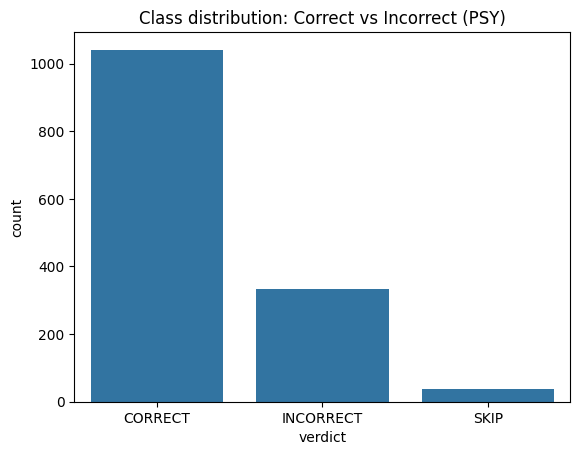

In [10]:
# EDA: target balance — essential to decide balancing strategy later
plt.figure()
sns.countplot(data=psy_all, x='verdict')
plt.title("Class distribution: Correct vs Incorrect (PSY)")
plt.show()


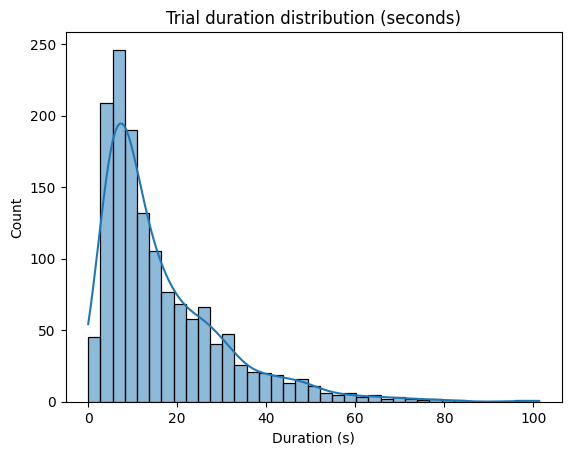

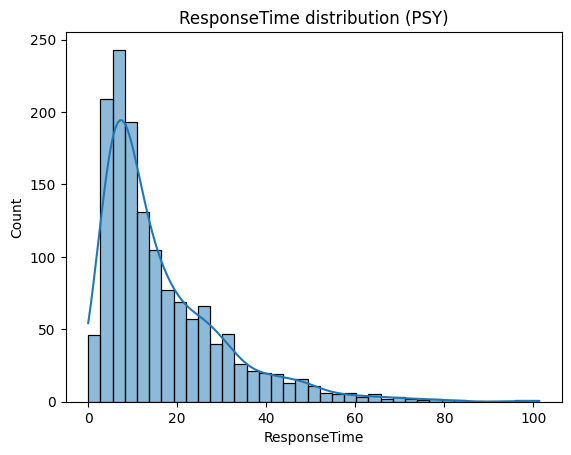

In [11]:
# EDA: trial durations and response times
psy_all['trial_duration_ms'] = psy_all['End_ms'] - psy_all['Start_ms']
plt.figure()
sns.histplot(psy_all['trial_duration_ms'].dropna()/1000, kde=True)  # plot in seconds
plt.title("Trial duration distribution (seconds)")
plt.xlabel("Duration (s)")
plt.show()

plt.figure()
sns.histplot(psy_all['ResponseTime'].dropna(), kde=True)
plt.title("ResponseTime distribution (PSY)")
plt.show()

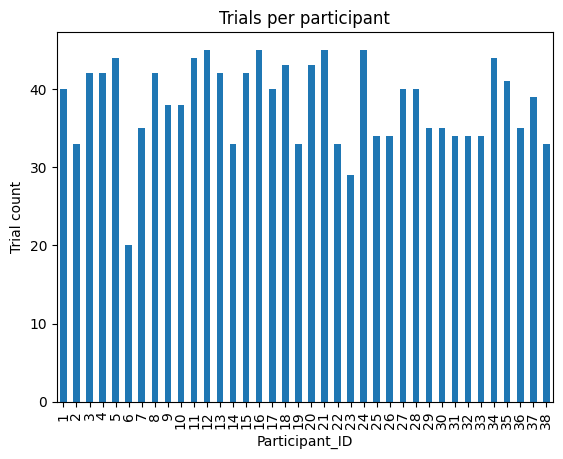

In [9]:
# Participant-level counts (to check for missing participants or uneven sample counts)
participant_counts = psy_all['Participant_ID'].value_counts().sort_index()
plt.figure()
participant_counts.plot(kind='bar')
plt.title("Trials per participant")
plt.xlabel("Participant_ID")
plt.ylabel("Trial count")
plt.show()

## **EEG_features.csv**
EEG_features.csv contains per-trial summaries of EEG signals aligned with each question window. It defines:
- Mean power per band: Delta, Theta, Alpha, Beta, Gamma — captures overall brain activity.
- Standard deviation: Theta, Alpha, Beta — measures variability within the trial.
- Cognitive ratios: Beta/Alpha (focused thinking), Theta/Beta (attention and cognitive control).

**Steps performed:**
1. Load per-participant EEG files.
2. Convert timestamps to milliseconds for alignment with PSY.csv trial windows.
3. Slice EEG data for each trial using `routineStart` and `routineEnd`.
4. **Compute per-trial features:**
   - **Mean power per band:** average of signal in Delta, Theta, Alpha, Beta, Gamma.
   - **Standard deviation per band:** variability within the trial for Theta, Alpha, Beta.
   - **Cognitive ratios:** Beta/Alpha ratio indicates focused thinking, Theta/Beta ratio reflects attention and cognitive control.
   - **Handling missing data:** `safe_mean` and `safe_std` ignore empty slices to avoid errors from missing segments.
5. Merge all trials into a single `EEG_features.csv` dataframe with `Participant_ID` and trial `Key` (`QuestionNumber`).

This file provides compact, interpretable EEG metrics per trial, enabling integration with other modalities for predicting correctness in mental rotation tasks.


In [13]:
all_eeg_features = []
print(" Extracting EEG features (keeping all samples)...")
for pid in range(1, NUM_PARTICIPANTS+1):
    eeg_file = os.path.join(DATA_DIR, str(pid), f"{pid}_EEG.csv")
    if not os.path.exists(eeg_file):
        print(f" EEG file missing for Participant {pid}")
        continue
    eeg = pd.read_csv(eeg_file, low_memory=False)
    eeg['ts_ms'] = eeg['UnixTime'] * 1000

    band_cols = [c for c in eeg.columns if any(b in c.lower() for b in ['delta','theta','alpha','beta','gamma'])]
    psy_pid = psy_all[psy_all['Participant_ID']==pid]

    for _, row in psy_pid.iterrows():
        trial = eeg[(eeg['ts_ms'] >= row['Start_ms']) & (eeg['ts_ms'] <= row['End_ms'])]

        # If trial is empty, features will be NaN
        theta_cols = [c for c in band_cols if 'theta' in c.lower()]
        alpha_cols = [c for c in band_cols if 'alpha' in c.lower()]
        beta_cols = [c for c in band_cols if 'beta' in c.lower()]
        gamma_cols = [c for c in band_cols if 'gamma' in c.lower()]
        delta_cols = [c for c in band_cols if 'delta' in c.lower()]

        feat = {
            'Key': row['Key'],
            'Participant_ID': pid,
            'Start_ms': row['Start_ms'],
            'End_ms': row['End_ms'],
            'eeg_mean_delta': safe_mean(trial[delta_cols].mean(axis=1)) if not trial.empty else np.nan,
            'eeg_mean_theta': safe_mean(trial[theta_cols].mean(axis=1)) if not trial.empty else np.nan,
            'eeg_mean_alpha': safe_mean(trial[alpha_cols].mean(axis=1)) if not trial.empty else np.nan,
            'eeg_mean_beta': safe_mean(trial[beta_cols].mean(axis=1)) if not trial.empty else np.nan,
            'eeg_mean_gamma': safe_mean(trial[gamma_cols].mean(axis=1)) if not trial.empty else np.nan,
            'eeg_std_theta': safe_std(trial[theta_cols].mean(axis=1)) if not trial.empty else np.nan,
            'eeg_std_alpha': safe_std(trial[alpha_cols].mean(axis=1)) if not trial.empty else np.nan,
            'eeg_std_beta': safe_std(trial[beta_cols].mean(axis=1)) if not trial.empty else np.nan,
            'eeg_beta_alpha_ratio': safe_mean(trial[beta_cols].mean(axis=1))/safe_mean(trial[alpha_cols].mean(axis=1)) if not trial.empty and safe_mean(trial[alpha_cols].mean(axis=1)) !=0 else np.nan,
            'eeg_theta_beta_ratio': safe_mean(trial[theta_cols].mean(axis=1))/safe_mean(trial[beta_cols].mean(axis=1)) if not trial.empty and safe_mean(trial[beta_cols].mean(axis=1)) !=0 else np.nan
        }
        all_eeg_features.append(feat)

eeg_df = pd.DataFrame(all_eeg_features)
cols = ['Key','Participant_ID'] + [c for c in eeg_df.columns if c not in ['Key','Participant_ID']]
eeg_df = eeg_df[cols]

eeg_df.to_csv(os.path.join(PREPROCESS_DIR, "EEG_features.csv"), index=False)
print(f"EEG features saved: {eeg_df.shape} (all trials kept, missing values as NaN)")


 Extracting EEG features (keeping all samples)...


/tmp/ipython-input-1720063769.py:37: RuntimeWarning: invalid value encountered in scalar divide
  'eeg_beta_alpha_ratio': safe_mean(trial[beta_cols].mean(axis=1))/safe_mean(trial[alpha_cols].mean(axis=1)) if not trial.empty and safe_mean(trial[alpha_cols].mean(axis=1)) !=0 else np.nan,
/tmp/ipython-input-1720063769.py:38: RuntimeWarning: invalid value encountered in scalar divide
  'eeg_theta_beta_ratio': safe_mean(trial[theta_cols].mean(axis=1))/safe_mean(trial[beta_cols].mean(axis=1)) if not trial.empty and safe_mean(trial[beta_cols].mean(axis=1)) !=0 else np.nan


EEG features saved: (1448, 14) (all trials kept, missing values as NaN)


In [14]:
display(eeg_df.head())

,Key,Participant_ID,Start_ms,End_ms,eeg_mean_delta,eeg_mean_theta,eeg_mean_alpha,eeg_mean_beta,eeg_mean_gamma,eeg_std_theta,eeg_std_alpha,eeg_std_beta,eeg_beta_alpha_ratio,eeg_theta_beta_ratio
0,1spl1,1,1.680003e+12,1.680003e+12,0.230229,0.172660,0.407933,0.266589,-0.208875,0.068551,0.093391,0.048627,0.653511,0.647664
1,1spl2,1,1.680003e+12,1.680003e+12,0.709148,0.405859,0.589369,0.322827,-0.059350,0.233898,0.220817,0.072398,0.547750,1.257203
2,1Item1,1,1.680003e+12,1.680003e+12,0.854009,0.528035,0.683743,0.366046,-0.103277,0.287131,0.169641,0.064204,0.535355,1.442539
3,1Item2,1,1.680003e+12,1.680003e+12,0.838483,0.515508,0.710686,0.297257,-0.144607,0.147355,0.140773,0.041330,0.418268,1.734214
4,1Item3,1,1.680003e+12,1.680003e+12,0.794340,0.446872,0.633282,0.308072,-0.158587,0.158837,0.151023,0.060047,0.486469,1.450542


In [15]:
display(eeg_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1448 entries, 0 to 1447
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Key                   1448 non-null   object 
 1   Participant_ID        1448 non-null   int64  
 2   Start_ms              1448 non-null   float64
 3   End_ms                1448 non-null   float64
 4   eeg_mean_delta        1364 non-null   float64
 5   eeg_mean_theta        1364 non-null   float64
 6   eeg_mean_alpha        1364 non-null   float64
 7   eeg_mean_beta         1364 non-null   float64
 8   eeg_mean_gamma        1364 non-null   float64
 9   eeg_std_theta         1363 non-null   float64
 10  eeg_std_alpha         1363 non-null   float64
 11  eeg_std_beta          1363 non-null   float64
 12  eeg_beta_alpha_ratio  1363 non-null   float64
 13  eeg_theta_beta_ratio  1363 non-null   float64
dtypes: float64(12), int64(1), object(1)
memory usage: 158.5+ KB


None

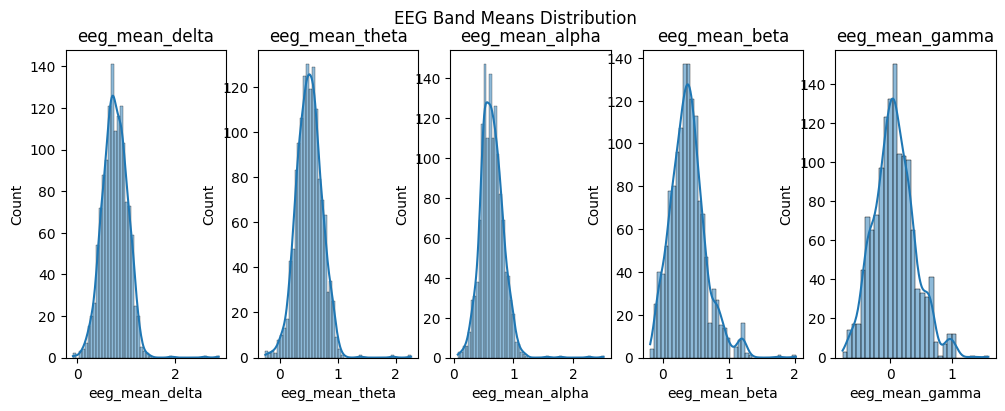

In [16]:
plot_distribution(eeg_df, ['eeg_mean_delta','eeg_mean_theta','eeg_mean_alpha','eeg_mean_beta','eeg_mean_gamma'], "EEG Band Means Distribution")

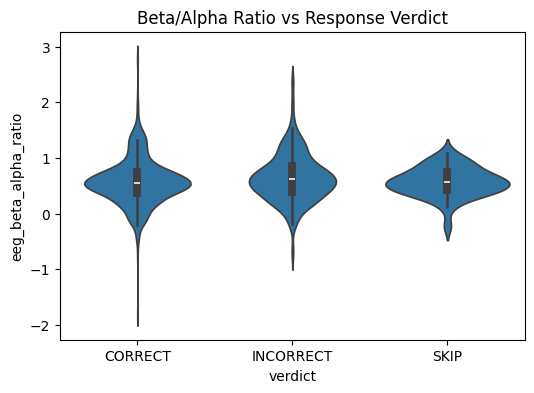

In [19]:
# Explore whether Beta/Alpha and Theta/Beta ratios differ between correct and incorrect trials
plt.figure(figsize=(6,4))
sns.violinplot(x='verdict', y='eeg_beta_alpha_ratio', data=eeg_df.merge(psy_all[['Participant_ID','Key','verdict']], on=['Participant_ID','Key']))
plt.title("Beta/Alpha Ratio vs Response Verdict")
plt.show()

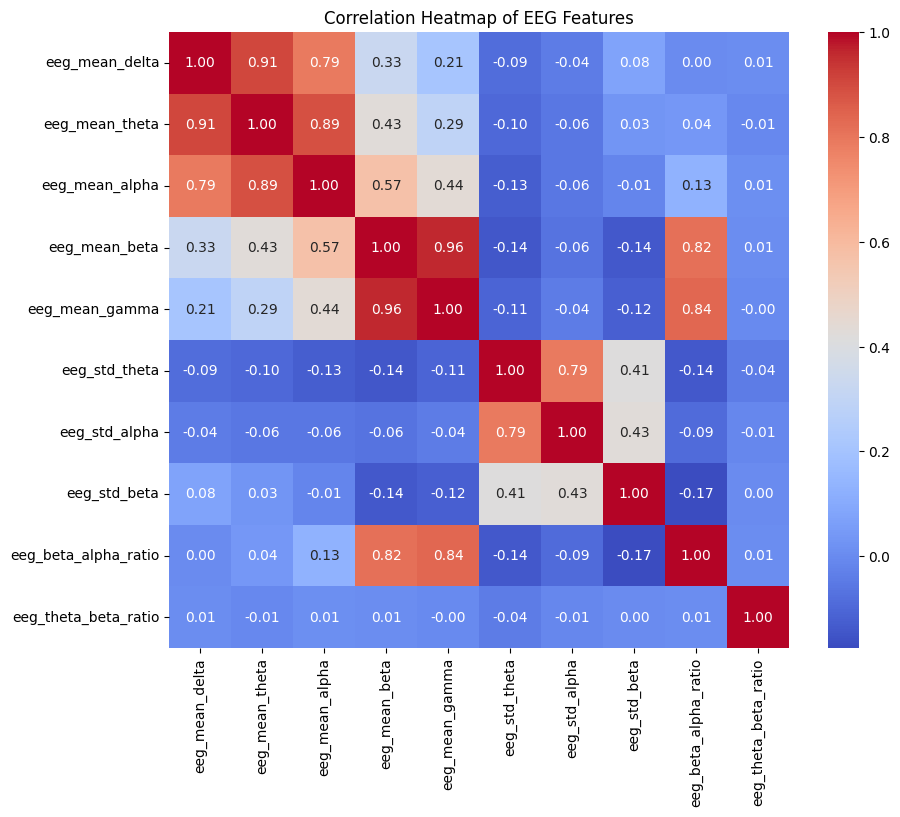

In [24]:
# Identify highly correlated features and understand feature relationships for preprocessing/feature selection.
plt.figure(figsize=(10,8))
sns.heatmap(eeg_df[bands + ['eeg_std_theta','eeg_std_alpha','eeg_std_beta','eeg_beta_alpha_ratio','eeg_theta_beta_ratio']].corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Correlation Heatmap of EEG Features")
plt.show()


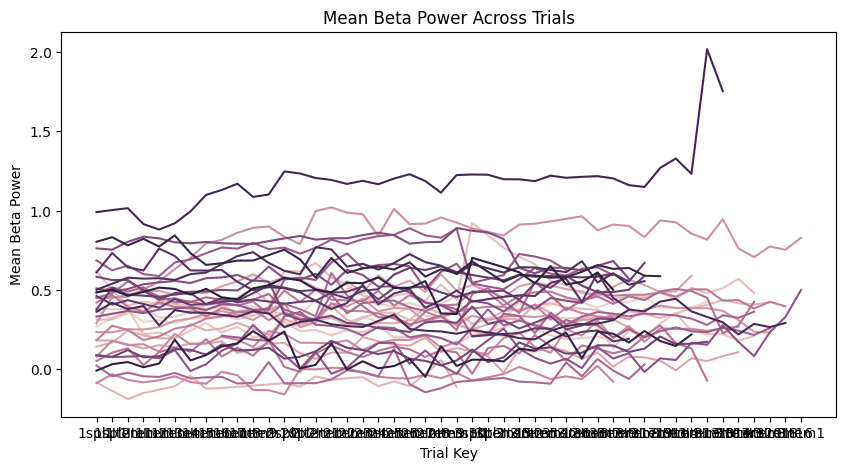

In [26]:
# Verify how mean EEG power changes across trials or participants, detect outlier trials or missing slices.
plt.figure(figsize=(10,5))
sns.lineplot(x='Key', y='eeg_mean_beta', hue='Participant_ID', data=eeg_df, legend=None)
plt.title("Mean Beta Power Across Trials")
plt.xlabel("Trial Key")
plt.ylabel("Mean Beta Power")
plt.show()


## **Eye_features.csv**
Eye_features.csv contains per-trial summaries of eye-tracking signals aligned with each question window. It defines:
- `eye_mean_pupil` — average pupil size (left and right) per trial.
- `eye_fixation_count` — number of recorded gaze points (fixations) during the trial.
- `eye_gaze_dispersion` — average distance between left and right gaze points, capturing visual scanning patterns.

**Steps performed:**
1. Load per-participant EYE.csv files.
2. Convert timestamps to milliseconds for alignment with PSY.csv trial windows.
3. Slice eye-tracking data for each trial using `routineStart` and `routineEnd`.
4. **Compute per-trial features:**
   - **Mean pupil size:** reflects cognitive load and arousal.
   - **Fixation count:** indicates visual attention and engagement with the task.
   - **Gaze dispersion:** captures scanning behavior and visual search patterns.
   - **Handling missing data:** `safe_mean` ensures computations do not fail for empty trials.
5. Merge all trials into a single `Eye_features.csv` dataframe with `Participant_ID` and trial `Key`.

This file provides compact eye-tracking metrics per trial, enabling integration with EEG, GSR, and facial features for multimodal prediction of response correctness.


In [27]:
all_eye_features = []
print("Extracting Eye features...")
for pid in range(1, NUM_PARTICIPANTS+1):
    eye_file = os.path.join(DATA_DIR, str(pid), f"{pid}_EYE.csv")
    if not os.path.exists(eye_file):
        print(f"Eye file missing for Participant {pid}")
        continue
    eye = pd.read_csv(eye_file, low_memory=False)
    eye['ts_ms'] = eye['UnixTime'] * 1000

    psy_pid = psy_all[psy_all['Participant_ID']==pid]

    for _, row in psy_pid.iterrows():
        trial = eye[(eye['ts_ms'] >= row['Start_ms']) & (eye['ts_ms'] <= row['End_ms'])]
        if trial.empty:
            continue
        feat = {
            'Key': row['Key'],
            'Participant_ID': pid,
            'Start_ms': row['Start_ms'],
            'End_ms': row['End_ms'],
            'eye_mean_pupil': safe_mean((trial['ET_PupilLeft']+trial['ET_PupilRight'])/2) if 'ET_PupilLeft' in trial.columns else np.nan,
            'eye_fixation_count': trial.shape[0],
            'eye_gaze_dispersion': safe_mean(np.sqrt((trial['ET_GazeLeftx']-trial['ET_GazeRightx'])**2 + (trial['ET_GazeLefty']-trial['ET_GazeRighty'])**2)) if 'ET_GazeLeftx' in trial.columns else np.nan,
          }
        all_eye_features.append(feat)

eye_df = pd.DataFrame(all_eye_features)
cols = ['Key','Participant_ID'] + [c for c in eye_df.columns if c not in ['Key','Participant_ID']]
eye_df = eye_df[cols]

eye_df.to_csv(os.path.join(PREPROCESS_DIR, "Eye_features.csv"), index=False)
print(f"Eye features saved: {eye_df.shape}")


Extracting Eye features...
Eye features saved: (1448, 7)


In [ ]:
display(eye_df.head())

,Key,Participant_ID,Start_ms,End_ms,eye_mean_pupil,eye_fixation_count,eye_gaze_dispersion
0,1spl1,1,1.680003e+12,1.680003e+12,0.188283,1200,126.931819
1,1spl2,1,1.680003e+12,1.680003e+12,0.246257,960,106.617668
2,1Item1,1,1.680003e+12,1.680003e+12,0.225902,960,114.222372
3,1Item2,1,1.680003e+12,1.680003e+12,0.206350,1680,128.769764
4,1Item3,1,1.680003e+12,1.680003e+12,0.037860,1920,180.514247


In [ ]:
display(eye_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1448 entries, 0 to 1447
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Key                  1448 non-null   object 
 1   Participant_ID       1448 non-null   int64  
 2   Start_ms             1448 non-null   float64
 3   End_ms               1448 non-null   float64
 4   eye_mean_pupil       1448 non-null   float64
 5   eye_fixation_count   1448 non-null   int64  
 6   eye_gaze_dispersion  1448 non-null   float64
dtypes: float64(4), int64(2), object(1)
memory usage: 79.3+ KB


None

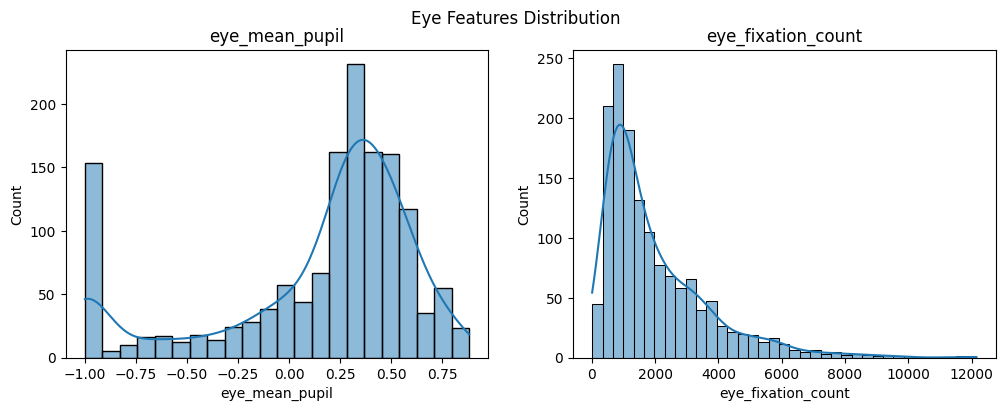

In [ ]:
plot_distribution(eye_df, ['eye_mean_pupil','eye_fixation_count'], "Eye Features Distribution")

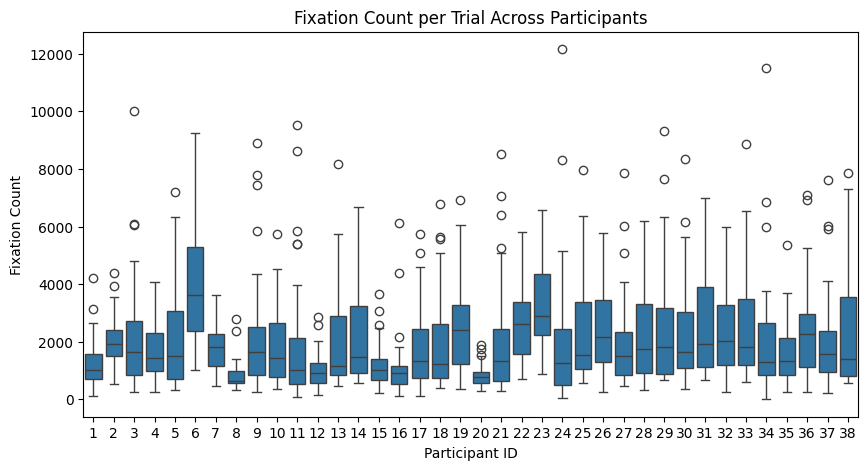

In [30]:
# Visualize how attention (fixations) varies across trials.
plt.figure(figsize=(10,5))
sns.boxplot(x='Participant_ID', y='eye_fixation_count', data=eye_df)
plt.title("Fixation Count per Trial Across Participants")
plt.xlabel("Participant ID")
plt.ylabel("Fixation Count")
plt.show()


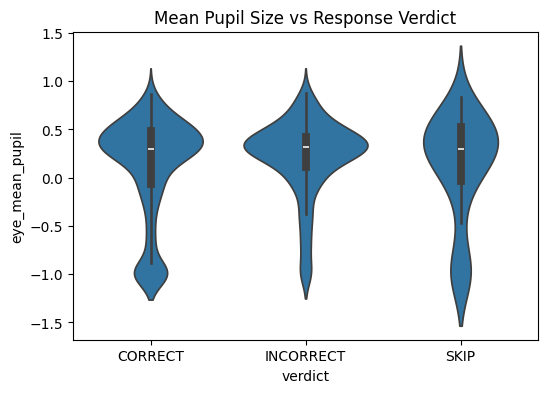

In [33]:
# Relationship Between Pupil Size and Verdict
merged_eye = eye_df.merge(psy_all[['Participant_ID','Key','verdict']], on=['Participant_ID','Key'])
plt.figure(figsize=(6,4))
sns.violinplot(x='verdict', y='eye_mean_pupil', data=merged_eye)
plt.title("Mean Pupil Size vs Response Verdict")
plt.show()


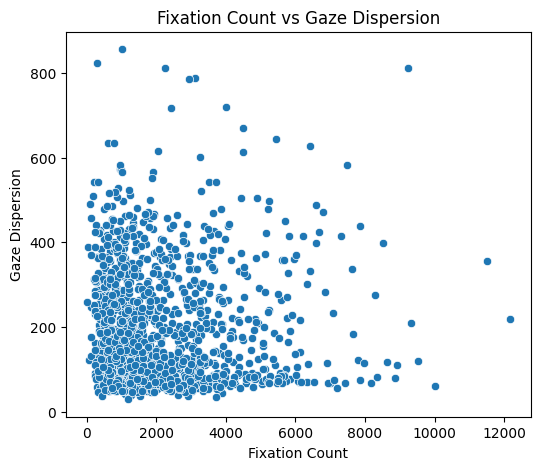

In [35]:
# Explore relationship between number of fixations and gaze dispersion, which may reflect visual scanning patterns.
plt.figure(figsize=(6,5))
sns.scatterplot(x='eye_fixation_count', y='eye_gaze_dispersion', data=eye_df)
plt.title("Fixation Count vs Gaze Dispersion")
plt.xlabel("Fixation Count")
plt.ylabel("Gaze Dispersion")
plt.show()


## **IVT_features.csv**
IVT_features.csv contains per-trial summaries of eye movement dynamics aligned with each question window. It defines:
- `ivt_mean_fix_dur` — average fixation duration per trial, reflecting sustained visual attention.
- `ivt_mean_sac_amp` — average saccade amplitude per trial, capturing visual scanning behavior.
- `ivt_fixation_count` — total number of fixations in the trial.
- `ivt_saccade_count` — total number of saccades in the trial.

**Steps performed:**
1. Load per-participant IVT.csv files.
2. Convert timestamps to milliseconds for alignment with PSY.csv trial windows.
3. Slice IVT data for each trial using `routineStart` and `routineEnd`.
4. **Compute per-trial features:**
   - **Mean fixation duration:** indicates how long participants focus on a point, reflecting attention.
   - **Mean saccade amplitude:** measures visual scanning range and exploration strategy.
   - **Fixation and saccade counts:** provide quantitative metrics of eye activity and task engagement.
   - **Handling missing data:** `safe_mean` ensures calculations do not fail on empty trials.
5. Merge all trials into a single `IVT_features.csv` dataframe with `Participant_ID` and trial `Key`.

This file provides quantitative eye activity metrics per trial, enabling integration with EEG, GSR, and facial features for multimodal prediction of response correctness.


In [38]:
all_ivt_features = []
print("Extracting IVT features...")
for pid in range(1, NUM_PARTICIPANTS+1):
    ivt_file = os.path.join(DATA_DIR, str(pid), f"{pid}_IVT.csv")
    if not os.path.exists(ivt_file):
        print(f" IVT file missing for Participant {pid}")
        continue
    ivt = pd.read_csv(ivt_file, low_memory=False)
    ivt['ts_ms'] = ivt['UnixTime'] * 1000

    psy_pid = psy_all[psy_all['Participant_ID']==pid]

    for _, row in psy_pid.iterrows():
        trial = ivt[(ivt['ts_ms'] >= row['Start_ms']) & (ivt['ts_ms'] <= row['End_ms'])]
        feat = {
            'Key': row['Key'],
            'Participant_ID': pid,
            'Start_ms': row['Start_ms'],
            'End_ms': row['End_ms'],
            'ivt_mean_fix_dur': safe_mean(trial['Fixation Duration']) if 'Fixation Duration' in trial.columns else np.nan,
            'ivt_mean_sac_amp': safe_mean(trial['Saccade Amplitude']) if 'Saccade Amplitude' in trial.columns else np.nan,
            'ivt_fixation_count': trial['Fixation Duration'].count() if 'Fixation Duration' in trial.columns else 0,
            'ivt_saccade_count': trial['Saccade Amplitude'].count() if 'Saccade Amplitude' in trial.columns else 0
        }
        all_ivt_features.append(feat)

ivt_df = pd.DataFrame(all_ivt_features)
cols = ['Key','Participant_ID'] + [c for c in ivt_df.columns if c not in ['Key','Participant_ID']]
ivt_df = ivt_df[cols]

ivt_df.to_csv(os.path.join(PREPROCESS_DIR, "IVT_features.csv"), index=False)
print(f" IVT features saved: {ivt_df.shape}")


Extracting IVT features...
 IVT features saved: (1448, 8)


In [39]:
display(ivt_df.head())

,Key,Participant_ID,Start_ms,End_ms,ivt_mean_fix_dur,ivt_mean_sac_amp,ivt_fixation_count,ivt_saccade_count
0,1spl1,1,1.680003e+12,1.680003e+12,1396.608000,7.956040,1055,112
1,1spl2,1,1.680003e+12,1.680003e+12,244.433747,6.454933,790,144
2,1Item1,1,1.680003e+12,1.680003e+12,456.356891,6.616173,843,96
3,1Item2,1,1.680003e+12,1.680003e+12,421.714542,5.070253,1445,192
4,1Item3,1,1.680003e+12,1.680003e+12,271.737413,5.191612,1560,251


In [40]:
display(ivt_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1448 entries, 0 to 1447
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Key                 1448 non-null   object 
 1   Participant_ID      1448 non-null   int64  
 2   Start_ms            1448 non-null   float64
 3   End_ms              1448 non-null   float64
 4   ivt_mean_fix_dur    1292 non-null   float64
 5   ivt_mean_sac_amp    1327 non-null   float64
 6   ivt_fixation_count  1448 non-null   int64  
 7   ivt_saccade_count   1448 non-null   int64  
dtypes: float64(4), int64(3), object(1)
memory usage: 90.6+ KB


None

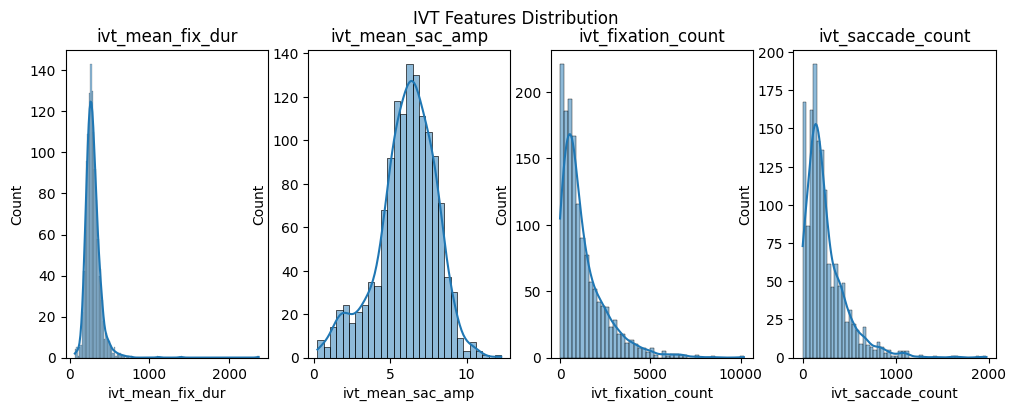

In [41]:
plot_distribution(ivt_df, ['ivt_mean_fix_dur','ivt_mean_sac_amp','ivt_fixation_count','ivt_saccade_count'], "IVT Features Distribution")


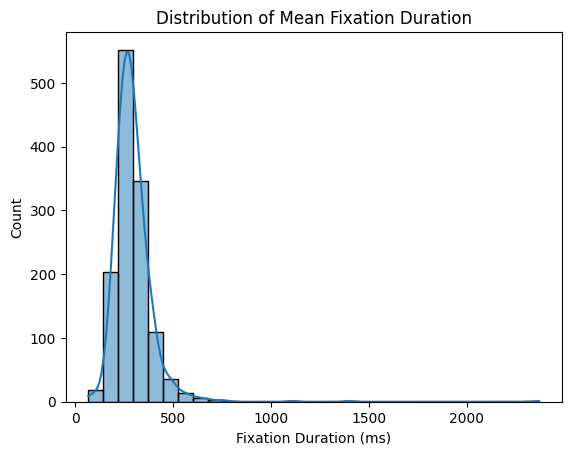

In [43]:
# Visualize typical attention span per trial.
sns.histplot(ivt_df['ivt_mean_fix_dur'], bins=30, kde=True)
plt.title("Distribution of Mean Fixation Duration")
plt.xlabel("Fixation Duration (ms)")
plt.show()


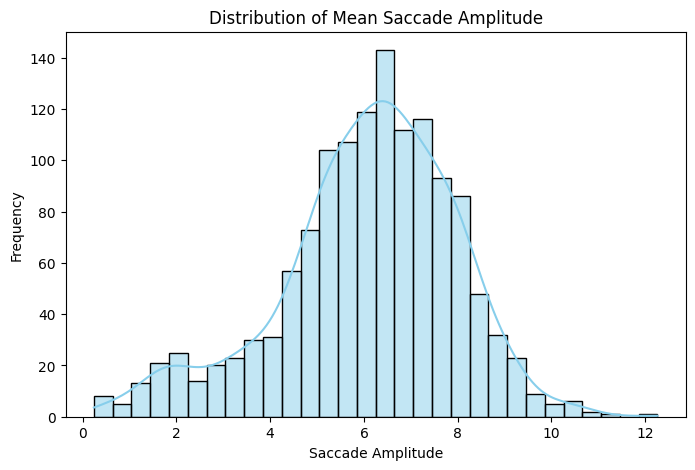

In [47]:
# Check visual scanning behavior across trials.
plt.figure(figsize=(8,5))
sns.histplot(ivt_df['ivt_mean_sac_amp'], bins=30, kde=True, color='skyblue')
plt.title("Distribution of Mean Saccade Amplitude")
plt.xlabel("Saccade Amplitude")
plt.ylabel("Frequency")
plt.show()



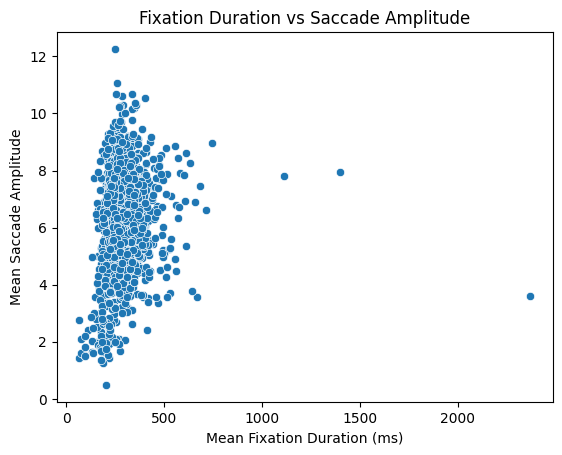

In [48]:
# Explore relationship between attention span and scanning behavior.
sns.scatterplot(x='ivt_mean_fix_dur', y='ivt_mean_sac_amp', data=ivt_df)
plt.title("Fixation Duration vs Saccade Amplitude")
plt.xlabel("Mean Fixation Duration (ms)")
plt.ylabel("Mean Saccade Amplitude")
plt.show()


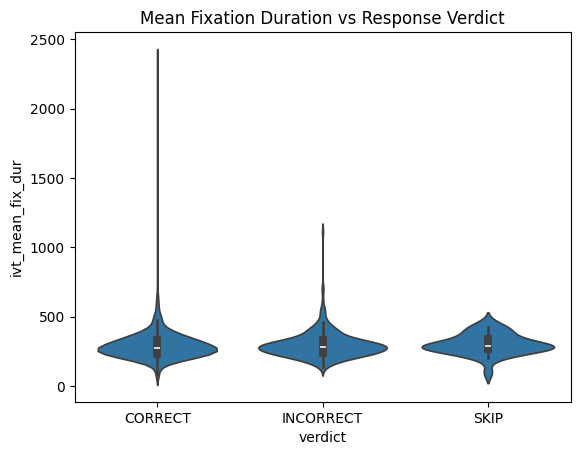

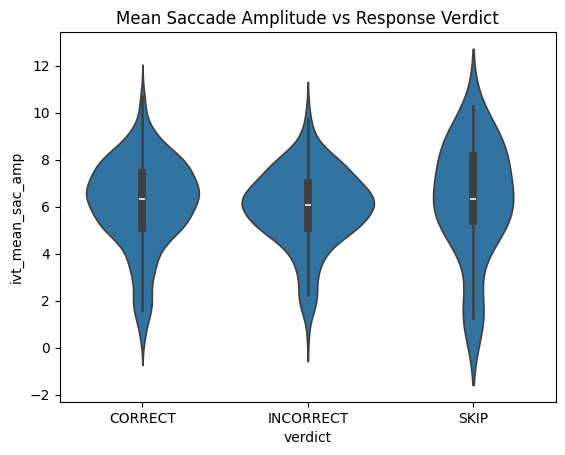

In [49]:
# Check if fixation or saccade patterns differ between correct and incorrect responses
merged_ivt = ivt_df.merge(psy_all[['Participant_ID','Key','verdict']], on=['Participant_ID','Key'])
sns.violinplot(x='verdict', y='ivt_mean_fix_dur', data=merged_ivt)
plt.title("Mean Fixation Duration vs Response Verdict")
plt.show()

sns.violinplot(x='verdict', y='ivt_mean_sac_amp', data=merged_ivt)
plt.title("Mean Saccade Amplitude vs Response Verdict")
plt.show()



## **GSR_features.csv**
GSR_features.csv contains per-trial summaries of Galvanic Skin Response (GSR) aligned with each question window. It defines:
- `gsr_mean` — average skin conductance per trial, reflecting baseline physiological arousal.
- `gsr_max` — maximum skin conductance, capturing peak arousal moments.
- `gsr_std` — standard deviation of conductance, indicating variability within the trial.
- `gsr_peak_count` — number of peaks detected in the trial, reflecting physiological spikes related to cognitive or emotional load.

**Steps performed:**
1. Load per-participant GSR.csv files.
2. Convert timestamps to milliseconds for alignment with PSY.csv trial windows.
3. Slice GSR data for each trial using `routineStart` and `routineEnd`.
4. **Compute per-trial features:**
   - **Mean and max:** summarize overall and peak arousal during the trial.
   - **Standard deviation:** captures variability in physiological response.
   - **Peak count:** reflects cognitive/emotional spikes, indicating engagement or stress.
   - **Handling missing data:** computations ignore empty trials to avoid errors.
5. Merge all trials into a single `GSR_features.csv` dataframe with `Participant_ID` and trial `Key`.

This file provides **physiological arousal metrics** per trial, enabling integration with EEG, Eye, and IVT features for multimodal prediction of response correctness in the mental rotation task.


In [50]:
all_gsr_features = []
print("Extracting GSR features...")
for pid in range(1, NUM_PARTICIPANTS+1):
    gsr_file = os.path.join(DATA_DIR, str(pid), f"{pid}_GSR.csv")
    if not os.path.exists(gsr_file):
        print(f"GSR file missing for Participant {pid}")
        continue
    gsr = pd.read_csv(gsr_file, low_memory=False)
    gsr['ts_ms'] = gsr['UnixTime'] * 1000

    psy_pid = psy_all[psy_all['Participant_ID']==pid]

    for _, row in psy_pid.iterrows():
        trial = gsr[(gsr['ts_ms'] >= row['Start_ms']) & (gsr['ts_ms'] <= row['End_ms'])]
        signal = pd.to_numeric(trial['GSR Conductance CAL'], errors='coerce').dropna() if 'GSR Conductance CAL' in trial.columns else pd.Series([])
        peaks, _ = find_peaks(signal.values) if len(signal)>0 else ([],[])
        feat = {
            'Key': row['Key'],
            'Participant_ID': pid,
            'Start_ms': row['Start_ms'],
            'End_ms': row['End_ms'],
            'gsr_mean': signal.mean() if len(signal)>0 else np.nan,
            'gsr_max': signal.max() if len(signal)>0 else np.nan,
            'gsr_std': signal.std() if len(signal)>0 else np.nan,
            'gsr_peak_count': len(peaks)
        }
        all_gsr_features.append(feat)

gsr_df = pd.DataFrame(all_gsr_features)
cols = ['Key','Participant_ID'] + [c for c in gsr_df.columns if c not in ['Key','Participant_ID']]
gsr_df = gsr_df[cols]

gsr_df.to_csv(os.path.join(PREPROCESS_DIR, "GSR_features.csv"), index=False)
print(f"GSR features saved: {gsr_df.shape}")


Extracting GSR features...
GSR features saved: (1448, 8)


In [51]:
display(gsr_df.head())


,Key,Participant_ID,Start_ms,End_ms,gsr_mean,gsr_max,gsr_std,gsr_peak_count
0,1spl1,1,1.680003e+12,1.680003e+12,18.241900,20.100960,1.388932,205
1,1spl2,1,1.680003e+12,1.680003e+12,18.086757,18.825287,0.394091,189
2,1Item1,1,1.680003e+12,1.680003e+12,17.447817,17.950540,0.236583,188
3,1Item2,1,1.680003e+12,1.680003e+12,17.714931,19.299109,0.661574,329
4,1Item3,1,1.680003e+12,1.680003e+12,16.470792,17.039345,0.299492,392


In [52]:
display(gsr_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1448 entries, 0 to 1447
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Key             1448 non-null   object 
 1   Participant_ID  1448 non-null   int64  
 2   Start_ms        1448 non-null   float64
 3   End_ms          1448 non-null   float64
 4   gsr_mean        1448 non-null   float64
 5   gsr_max         1448 non-null   float64
 6   gsr_std         1448 non-null   float64
 7   gsr_peak_count  1448 non-null   int64  
dtypes: float64(5), int64(2), object(1)
memory usage: 90.6+ KB


None

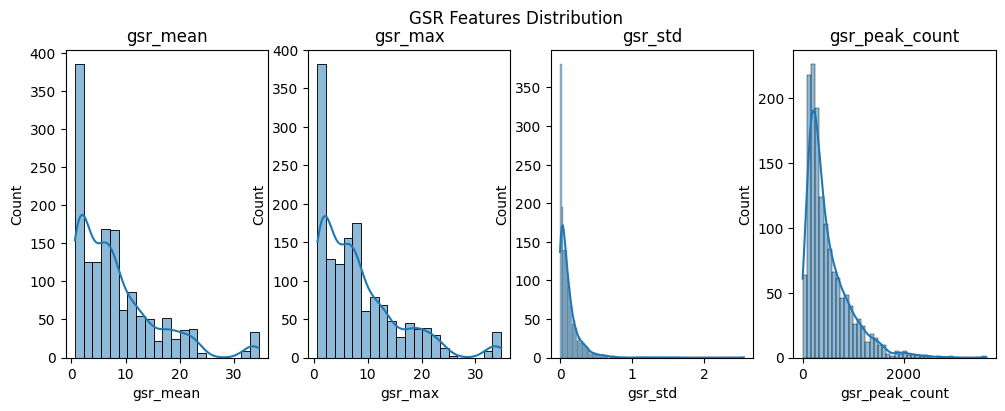

In [53]:
plot_distribution(gsr_df, ['gsr_mean','gsr_max','gsr_std','gsr_peak_count'], "GSR Features Distribution")

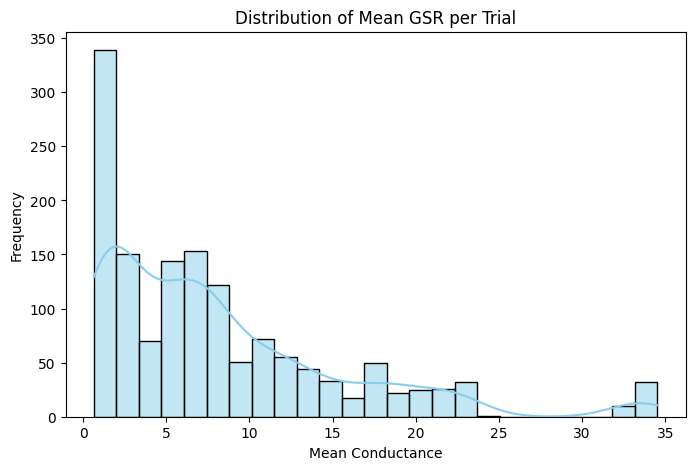

In [54]:
# Understand overall baseline arousal across trials

plt.figure(figsize=(8,5))
sns.histplot(gsr_df['gsr_mean'], bins=25, kde=True, color='skyblue')
plt.title("Distribution of Mean GSR per Trial")
plt.xlabel("Mean Conductance")
plt.ylabel("Frequency")
plt.show()

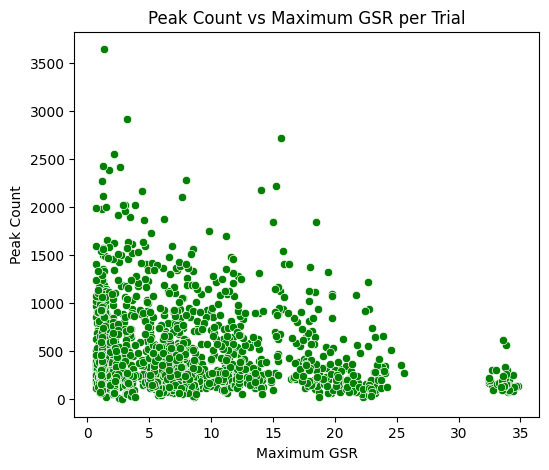

In [55]:
# Check relationship between intensity of arousal and number of spikes.
plt.figure(figsize=(6,5))
sns.scatterplot(x='gsr_max', y='gsr_peak_count', data=gsr_df, color='green')
plt.title("Peak Count vs Maximum GSR per Trial")
plt.xlabel("Maximum GSR")
plt.ylabel("Peak Count")
plt.show()


/tmp/ipython-input-639729148.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='verdict', y='gsr_mean', data=merged_gsr, palette='Set2')


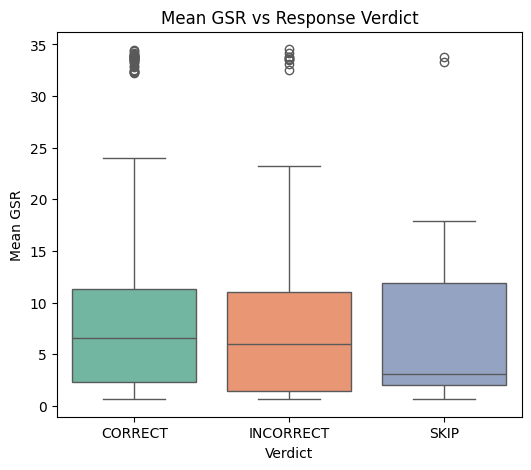

In [57]:
# Investigate if correct/incorrect trials differ in arousal.
merged_gsr = gsr_df.merge(psy_all[['Participant_ID','Key','verdict']], on=['Participant_ID','Key'])

plt.figure(figsize=(6,5))
sns.boxplot(x='verdict', y='gsr_mean', data=merged_gsr, palette='Set2')
plt.title("Mean GSR vs Response Verdict")
plt.xlabel("Verdict")
plt.ylabel("Mean GSR")
plt.show()


## **TIVA_features.csv**
TIVA_features.csv contains per-trial summaries of facial expression and affective state metrics aligned with each question window. It defines:
- Emotion scores: `Anger`, `Contempt`, `Disgust`, `Fear`, `Joy`, `Sadness`, `Surprise`
- Engagement and attention metrics: `Engagement`, `Valence`, `Confusion`, `Neutral`, `Attention`
- `BlinkRate` — average blink rate per trial

**Steps performed:**
1. Load per-participant TIVA.csv files.
2. Convert timestamps to milliseconds for alignment with PSY.csv trial windows.
3. Slice TIVA data for each trial using `routineStart` and `routineEnd`.
4. **Compute per-trial features: mean and maximum of each emotion and engagement metric.**  
   - **Why:** Summarizing over the trial captures the overall affective state (mean) and peak reactions (max), which may influence task performance and help the model detect emotional or attention-driven patterns affecting correctness.
5. Merge all trials into a single `TIVA_features.csv` dataframe with `Participant_ID` and trial `Key`.

This file provides **facial expression and affective state metrics** per trial, enabling integration with EEG, Eye, IVT, and GSR features for multimodal prediction of response correctness.


In [58]:
all_tiva_features = []
print(" Extracting TIVA features...")
important_tiva_cols = ['Anger','Contempt','Disgust','Fear','Joy','Sadness','Surprise',
                       'Engagement','Valence','Confusion','Neutral','Attention','BlinkRate']

for pid in range(1, NUM_PARTICIPANTS+1):
    tiva_file = os.path.join(DATA_DIR, str(pid), f"{pid}_TIVA.csv")
    if not os.path.exists(tiva_file):
        print(f" TIVA file missing for Participant {pid}")
        continue
    tiva = pd.read_csv(tiva_file, low_memory=False)
    tiva['ts_ms'] = tiva['UnixTime'] * 1000

    psy_pid = psy_all[psy_all['Participant_ID']==pid]

    for _, row in psy_pid.iterrows():
        trial = tiva[(tiva['ts_ms'] >= row['Start_ms']) & (tiva['ts_ms'] <= row['End_ms'])]
        feat = {'Key': row['Key'], 'Participant_ID': pid, 'Start_ms': row['Start_ms'], 'End_ms': row['End_ms']}
        for col in important_tiva_cols:
            feat[f'tiva_mean_{col.lower()}'] = safe_mean(trial[col]) if col in trial.columns else np.nan
            feat[f'tiva_max_{col.lower()}'] = trial[col].max() if col in trial.columns else np.nan
        all_tiva_features.append(feat)

tiva_df = pd.DataFrame(all_tiva_features)
cols = ['Key','Participant_ID'] + [c for c in tiva_df.columns if c not in ['Key','Participant_ID']]
tiva_df = tiva_df[cols]

tiva_df.to_csv(os.path.join(PREPROCESS_DIR, "TIVA_features.csv"), index=False)
print(f" TIVA features saved: {tiva_df.shape}")


 Extracting TIVA features...
 TIVA features saved: (1448, 30)


In [59]:
display(tiva_df.head())

,Key,Participant_ID,Start_ms,End_ms,tiva_mean_anger,tiva_max_anger,tiva_mean_contempt,tiva_max_contempt,tiva_mean_disgust,tiva_max_disgust,...,tiva_mean_valence,tiva_max_valence,tiva_mean_confusion,tiva_max_confusion,tiva_mean_neutral,tiva_max_neutral,tiva_mean_attention,tiva_max_attention,tiva_mean_blinkrate,tiva_max_blinkrate
0,1spl1,1,1.680003e+12,1.680003e+12,0.129380,0.154047,0.192026,0.192736,0.024671,0.031868,...,0.0,0.0,0.001485,0.006085,99.600280,99.618683,97.983404,98.754173,0.000000,0.0
1,1spl2,1,1.680003e+12,1.680003e+12,0.127418,0.131842,0.191539,0.192651,0.024042,0.024329,...,0.0,0.0,0.001340,0.006678,99.616922,99.633865,97.835235,98.224716,0.000000,0.0
2,1Item1,1,1.680003e+12,1.680003e+12,0.136003,0.224068,0.189046,0.192675,0.024325,0.026854,...,0.0,0.0,0.002007,0.011253,99.596406,99.637833,97.571289,98.103561,0.000000,0.0
3,1Item2,1,1.680003e+12,1.680003e+12,0.129097,0.153570,0.191388,0.192658,0.024068,0.024661,...,0.0,0.0,0.001570,0.003732,99.617223,99.628273,97.176145,97.936546,0.000000,0.0
4,1Item3,1,1.680003e+12,1.680003e+12,0.129881,0.198665,0.190927,0.192745,0.024051,0.024756,...,0.0,0.0,0.001822,0.006987,99.616666,99.633286,96.939123,97.773972,0.689189,6.0


In [60]:
display(tiva_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1448 entries, 0 to 1447
Data columns (total 30 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Key                   1448 non-null   object 
 1   Participant_ID        1448 non-null   int64  
 2   Start_ms              1448 non-null   float64
 3   End_ms                1448 non-null   float64
 4   tiva_mean_anger       1448 non-null   float64
 5   tiva_max_anger        1448 non-null   float64
 6   tiva_mean_contempt    1448 non-null   float64
 7   tiva_max_contempt     1448 non-null   float64
 8   tiva_mean_disgust     1448 non-null   float64
 9   tiva_max_disgust      1448 non-null   float64
 10  tiva_mean_fear        1448 non-null   float64
 11  tiva_max_fear         1448 non-null   float64
 12  tiva_mean_joy         1448 non-null   float64
 13  tiva_max_joy          1448 non-null   float64
 14  tiva_mean_sadness     1448 non-null   float64
 15  tiva_max_sadness     

None

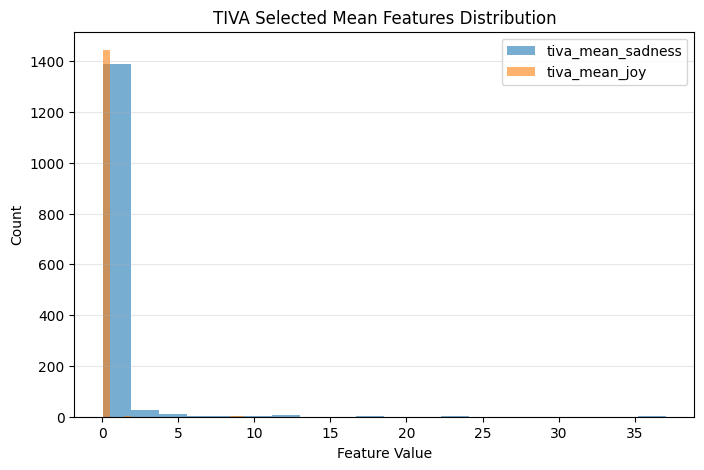

In [61]:
tiva_cols = [f'tiva_mean_{c.lower()}' for c in ['Sadness','Joy']]

# Plotting
plt.figure(figsize=(8,5))
for col in tiva_cols:
    plt.hist(tiva_df[col].dropna(), bins=20, alpha=0.6, label=col)

plt.title("TIVA Selected Mean Features Distribution")
plt.xlabel("Feature Value")
plt.ylabel("Count")
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.show()


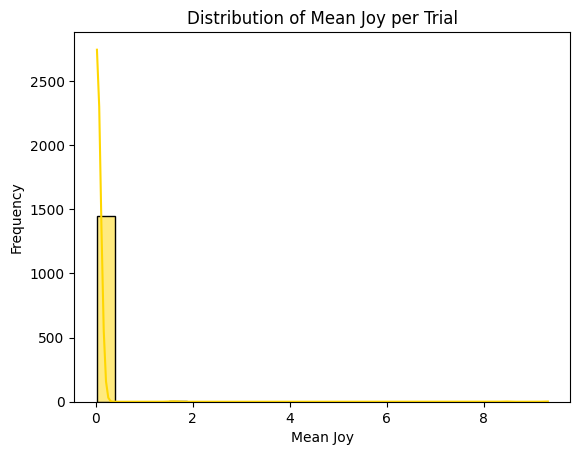

In [63]:
# Understand overall positive affect across trials
sns.histplot(tiva_df['tiva_mean_joy'], bins=25, kde=True, color='gold')
plt.title("Distribution of Mean Joy per Trial")
plt.xlabel("Mean Joy")
plt.ylabel("Frequency")
plt.show()


/tmp/ipython-input-1124862818.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Participant_ID', y='tiva_mean_blinkrate', data=tiva_df, palette='coolwarm')


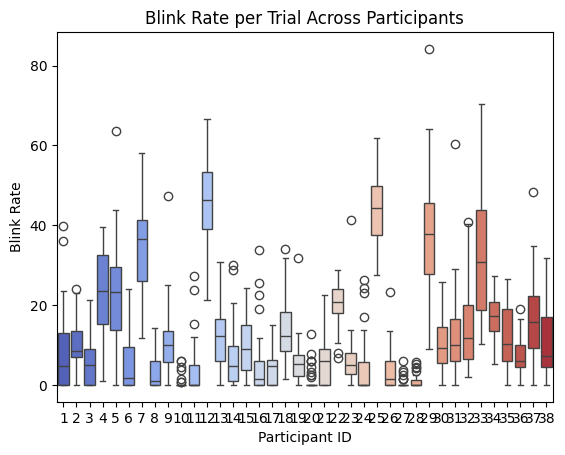

In [64]:
# Identify variability in eye activity and attention patterns across participants
sns.boxplot(x='Participant_ID', y='tiva_mean_blinkrate', data=tiva_df, palette='coolwarm')
plt.title("Blink Rate per Trial Across Participants")
plt.xlabel("Participant ID")
plt.ylabel("Blink Rate")
plt.show()


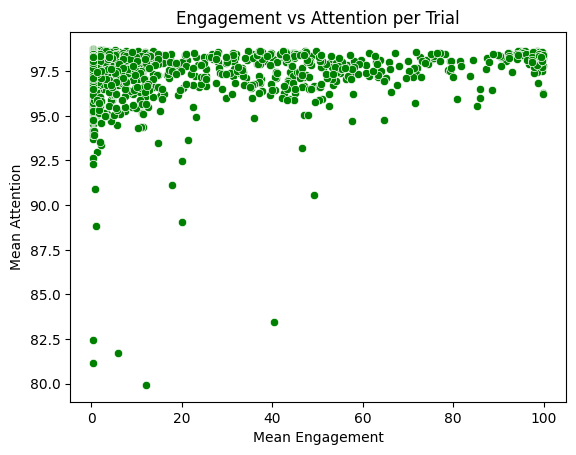

In [67]:
# Explore the relationship between participant focus and engagement.
sns.scatterplot(x='tiva_mean_engagement', y='tiva_mean_attention', data=tiva_df, color='green')
plt.title("Engagement vs Attention per Trial")
plt.xlabel("Mean Engagement")
plt.ylabel("Mean Attention")
plt.show()


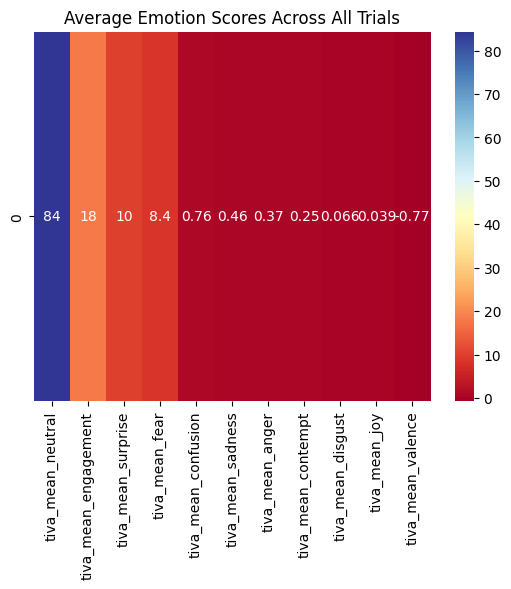

In [69]:
# Quickly visualize overall emotional patterns across all trials.
emotion_cols = [c for c in tiva_df.columns if 'tiva_mean_' in c and c not in ['tiva_mean_attention','tiva_mean_blinkrate']]
emotion_means = tiva_df[emotion_cols].mean().sort_values(ascending=False)

sns.heatmap(emotion_means.to_frame().T, annot=True, cmap='RdYlBu', cbar=True)
plt.title("Average Emotion Scores Across All Trials")
plt.show()


## **Complete_Preprocessed.csv**

**Purpose:** Merge all modality-specific features (EEG, Eye, IVT, GSR, TIVA) with PSY trial metadata into a single trial-level dataset.  

**Steps performed:**
1. Merge features using `Key`, `Participant_ID`, `Start_ms`, and `End_ms` to ensure correct alignment of all modalities per trial.
2. Missing values are retained as NaN to allow downstream imputation or model-specific handling.
3. The final dataframe contains per-trial features across **all modalities**, along with the target `verdict`.

**Why it’s useful for model building:**
- Ensures **synchronized multimodal inputs** for each trial, critical for accurate classification of response correctness.
- Enables **multimodal feature fusion** for models like Random Forest, XGBoost, or LSTM/Transformer-based architectures.
- Facilitates **exploratory analysis** and correlation checks across different modalities.
- Maintains **trial-level granularity**, preserving temporal context and allowing potential time-series modeling.



In [70]:
print(" Merging all features into Complete_Preprocessed.csv...")
final_df = psy_all.merge(eeg_df, on=['Key','Participant_ID','Start_ms','End_ms'], how='left')
final_df = final_df.merge(eye_df, on=['Key','Participant_ID','Start_ms','End_ms'], how='left')
final_df = final_df.merge(ivt_df, on=['Key','Participant_ID','Start_ms','End_ms'], how='left')
final_df = final_df.merge(gsr_df, on=['Key','Participant_ID','Start_ms','End_ms'], how='left')
final_df = final_df.merge(tiva_df, on=['Key','Participant_ID','Start_ms','End_ms'], how='left')

final_save_fp = os.path.join(PREPROCESS_DIR, "Complete_Preprocessed.csv")
final_df.to_csv(final_save_fp, index=False)
print(f" Final merged features saved: {final_df.shape}")


 Merging all features into Complete_Preprocessed.csv...
 Final merged features saved: (1448, 59)


In [ ]:
display(final_df.head())

,Key,Participant_ID,Category,QuestionNumber,Difficulty,ResponseTime,routineStart,routineEnd,verdict,Start_ms,...,tiva_mean_valence,tiva_max_valence,tiva_mean_confusion,tiva_max_confusion,tiva_mean_neutral,tiva_max_neutral,tiva_mean_attention,tiva_max_attention,tiva_mean_blinkrate,tiva_max_blinkrate
0,1spl1,1,1,spl1,Easy,10.369816,1.680003e+09,1.680003e+09,CORRECT,1.680003e+12,...,0.0,0.0,0.001485,0.006085,99.600280,99.618683,97.983404,98.754173,0.000000,0.0
1,1spl2,1,1,spl2,Easy,7.913991,1.680003e+09,1.680003e+09,CORRECT,1.680003e+12,...,0.0,0.0,0.001340,0.006678,99.616922,99.633865,97.835235,98.224716,0.000000,0.0
2,1Item1,1,1,Item1,Easy,7.654472,1.680003e+09,1.680003e+09,CORRECT,1.680003e+12,...,0.0,0.0,0.002007,0.011253,99.596406,99.637833,97.571289,98.103561,0.000000,0.0
3,1Item2,1,1,Item2,Easy,14.597205,1.680003e+09,1.680003e+09,CORRECT,1.680003e+12,...,0.0,0.0,0.001570,0.003732,99.617223,99.628273,97.176145,97.936546,0.000000,0.0
4,1Item3,1,1,Item3,Easy,16.476565,1.680003e+09,1.680003e+09,CORRECT,1.680003e+12,...,0.0,0.0,0.001822,0.006987,99.616666,99.633286,96.939123,97.773972,0.689189,6.0


In [ ]:
display(final_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1448 entries, 0 to 1447
Data columns (total 58 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Key                   1448 non-null   object 
 1   Participant_ID        1448 non-null   int64  
 2   Category              1448 non-null   int64  
 3   QuestionNumber        1448 non-null   object 
 4   Difficulty            1410 non-null   object 
 5   ResponseTime          1448 non-null   float64
 6   routineStart          1448 non-null   float64
 7   routineEnd            1448 non-null   float64
 8   verdict               1410 non-null   object 
 9   Start_ms              1448 non-null   float64
 10  End_ms                1448 non-null   float64
 11  eeg_mean_delta        1364 non-null   float64
 12  eeg_mean_theta        1364 non-null   float64
 13  eeg_mean_alpha        1364 non-null   float64
 14  eeg_mean_beta         1364 non-null   float64
 15  eeg_mean_gamma       

None

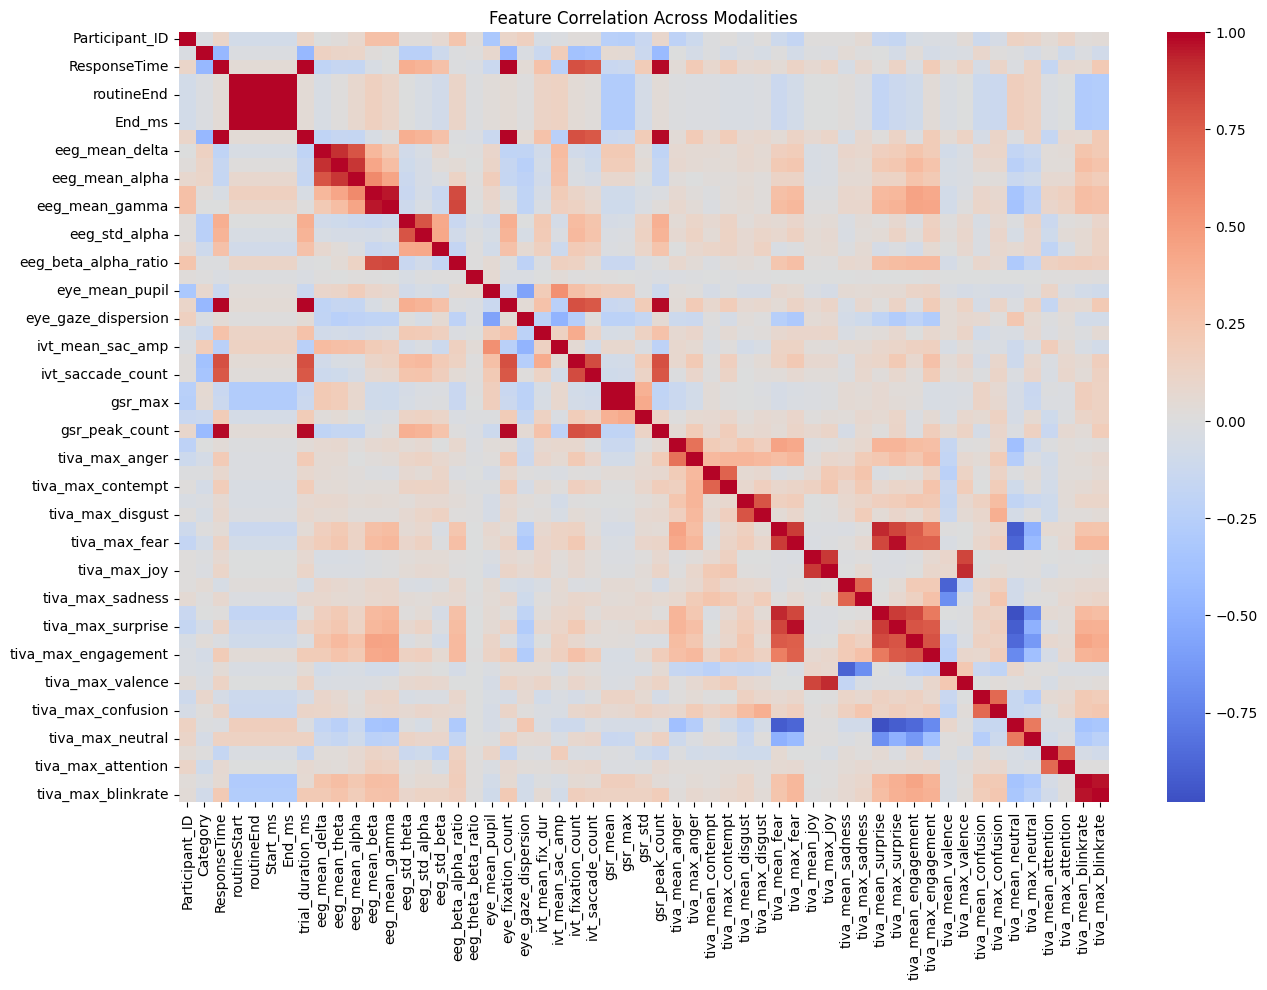

In [72]:
# Identify strong/weak correlations between EEG, Eye, IVT, GSR, and TIVA features.
plt.figure(figsize=(15,10))
corr_matrix = final_df.select_dtypes(include=['float64','int64']).corr()
sns.heatmap(corr_matrix, cmap='coolwarm', center=0, annot=False)
plt.title("Feature Correlation Across Modalities")
plt.show()

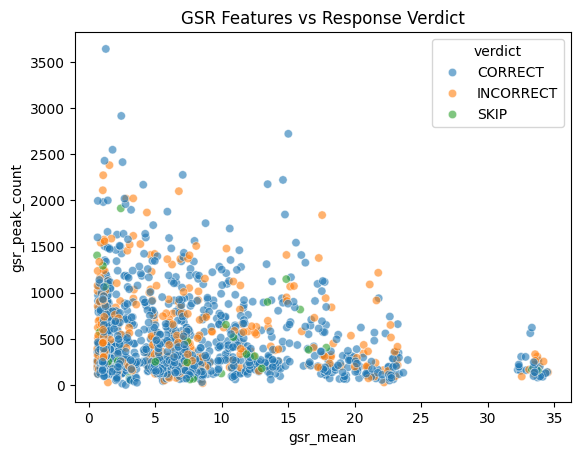

In [75]:
# Check if physiological arousal patterns differ between correct and incorrect trials.
sns.scatterplot(x='gsr_mean', y='gsr_peak_count', hue='verdict', data=final_df, alpha=0.6)
plt.title("GSR Features vs Response Verdict")
plt.show()
